<a href="https://colab.research.google.com/github/LeaCarop/BinaryClassification/blob/main/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [6]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # Mezclo el conjunto de entrenamiento

In [7]:
# Calculo el Z-scores de cada columna en el conjunto de entrenamiento y lo incluyo en el nuevo DataFrame
train_df_mean = train_df.mean()  # media
train_df_std = train_df.std()    # desviación estandar
train_df_norm = (train_df - train_df_mean)/train_df_std    # calculo Z

train_df_norm.head() # Los puntuajes Z se encuentran entre-2 y 2

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9233,0.2,-0.1,-1.2,2.9,3.2,3.0,3.4,-0.3,-0.9
1695,1.2,-1.3,0.4,-0.3,0.2,-0.3,0.2,-0.9,0.2
16944,-2.3,2.4,-0.4,-0.9,-1.0,-1.0,-1.0,0.2,-0.7
5457,0.7,-0.8,0.4,-0.5,-0.1,0.5,-0.0,-1.1,-0.6
16800,-1.8,1.6,0.2,-1.0,-1.1,-1.0,-1.1,-0.6,-0.7


In [8]:
# Hago lo mismo para el conjunto de validación
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [9]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


**PRIMER PASO:** Crear una etiqueta binaria para el conjunto de datos.

In [10]:
threshold = 265000   # es el percentil 75 de median_house_value
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)

# Los barrios con un precio medio de la vivienda superior a 265000 tendrán valor 1, el resto de barrios,
# con un valor inferior, tendrán valor 0.

9233    0.0
1695    0.0
16944   0.0
5457    0.0
16800   0.0
         ..
9972    0.0
4443    0.0
3827    0.0
11253   0.0
6415    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

**SEGUNDO PASO:** Representar características en columnas de características

In [11]:
# Lista vacía para 
feature_columns = []

# Columna numérica para representar median_income
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Columna numérica para representar total_rooms. 
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convierto la lista vacía en una capa Densa que luego se incorpora al modelo 
feature_layer = layers.DenseFeatures(feature_columns)

# Imprimir primeras y últimas 3 filas de feature_layer
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.25028247,  2.9282067 ],
       [-0.880105  , -0.30444062],
       [ 0.16865592, -0.946658  ],
       ...,
       [ 0.30994412, -0.70995504],
       [-0.4687656 ,  0.2909867 ],
       [-1.1909286 , -1.059046  ]], dtype=float32)>

**TERCER PASO:** Definir las funciones principales del modelo

In [12]:
def crear_modelo(my_learning_rate, feature_layer, my_metrics):
  model = tf.keras.models.Sequential()

  model.add(feature_layer)

  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)
  
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  epochs = history.epoch

  hist = pd.DataFrame(history.history)

  return epochs, hist  

In [14]:
def plot_curve(epochs, hist, list_of_metrics):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Valor")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

**CUARTO PASO:** Hiperparámetros y entrenamiento del modelo

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
170/170 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.2619
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6071 - accuracy: 0.2646
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5443 - accuracy: 0.4986
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.6989
Epoch 5/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4649 - accuracy: 0.7592
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4408 - accuracy: 0.7869
Epoch 7/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4240 - accuracy: 0.7998
Epoch 8/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4131 - accuracy: 0.8058
Epoch 9/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4060 - accuracy: 0.8077
Epoch 10/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4018 - accuracy: 0.8088

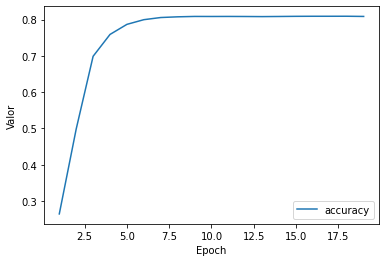

In [15]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

my_model = crear_modelo(learning_rate, feature_layer, METRICS)

#entrenar con train set
epochs, hist = train(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

El AUC (área debajo de la curva) tiene un valor diagnóstico = 0.8. Este valor puede ir mejorando gradualmente, durante el entrenamiento del modelo.

**SEXTO PASO:** Evaluar el modelo con el conjunto de prueba

In [16]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8010


[0.4068470001220703, 0.8009999990463257]

Se obtiene una precisión muy similar a la alcanzada con el conjunto de entrenamiento.

**SÉPTIMO PASO:** Añadir métricas.

Antes solo tuve en cuenta la exactitd (accuracy), pero, ahora, añadiré otras métricas al modelo como son, recuerdo (recall) y precisión (F1).

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 0.5386 - accuracy: 0.5872 - precision: 0.3678 - recall: 0.9077
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4992 - accuracy: 0.6386 - precision: 0.3982 - recall: 0.8729
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.6842 - precision: 0.4318 - recall: 0.8368
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.7195 - precision: 0.4642 - recall: 0.7947
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.7429 - precision: 0.4905 - recall: 0.7481
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4147 - accuracy: 0.7686 - precision: 0.5275 - recall: 0.7101
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4060 - accuracy: 0.7836 - precision: 0.5546 - recall: 0.6800
Epoch 8/20
170/170 [==============================] 

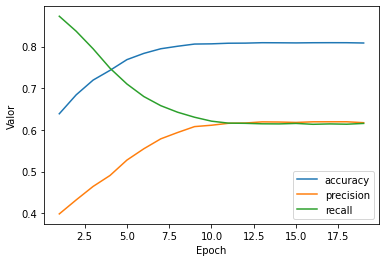

In [24]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name='recall'),
          ]

my_model = crear_modelo(learning_rate, feature_layer, METRICS)

epochs, hist = train(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 0.8601 - accuracy: 0.4420 - precision: 0.1183 - recall: 0.1912
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.7689 - accuracy: 0.5979 - precision: 0.1392 - recall: 0.1175
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.6969 - precision: 0.1988 - recall: 0.0704
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6223 - accuracy: 0.7280 - precision: 0.2490 - recall: 0.0440
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7421 - precision: 0.3425 - recall: 0.0351
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.7542 - precision: 0.5955 - recall: 0.0499
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7686 - precision: 0.8178 - recall: 0.0951
Epoch 8/20
170/170 [==============================] 

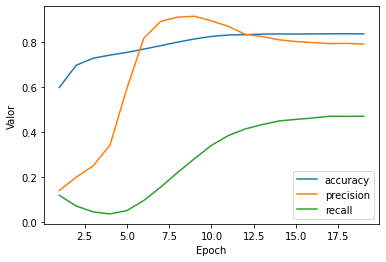

In [27]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52   # nuevo valor límite
label_name = "median_house_value_is_high"

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
          ]

my_model = crear_modelo(learning_rate, feature_layer, METRICS)

epochs, hist = train(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 2ms/step - loss: 0.6167 - accuracy: 0.7811 - precision: 0.6737 - recall: 0.2402
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.7838 - precision: 0.7097 - recall: 0.2279
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.7878 - precision: 0.7726 - recall: 0.2136
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7875 - precision: 0.8170 - recall: 0.1924
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4549 - accuracy: 0.7860 - precision: 0.8570 - recall: 0.1721
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.7836 - precision: 0.9023 - recall: 0.1500
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4150 - accuracy: 0.7835 - precision: 0.9436 - recall: 0.1417
Epoch 8/20
170/170 [==============================] 

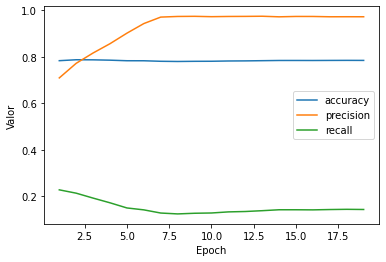

In [28]:
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.90   # nuevo valor límite
label_name = "median_house_value_is_high"

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
          ]

my_model = crear_modelo(learning_rate, feature_layer, METRICS)

epochs, hist = train(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

**Resumen:**
- Un 'classification_threshod' de 0.53 produce una exactitud (accuracy) del 83% aproximadamente.
- Un 'classification_threshod' de 0.90 reduce la exactitud un 5% aprox, con un valor de 0.785.
- Un 'classification_threshod' de 0.35 produce una exactitud de 0.8 aprox.

**RENDIMIENTO GENERAL DEL MODELO** (AUC: área bajo la curva)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 3ms/step - loss: 0.6617 - auc: 0.7202
Epoch 2/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5945 - auc: 0.7611
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5379 - auc: 0.7888
Epoch 4/20
170/170 [==============================] - 1s 4ms/step - loss: 0.4932 - auc: 0.8071
Epoch 5/20
170/170 [==============================] - 1s 3ms/step - loss: 0.4573 - auc: 0.8199
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4325 - auc: 0.8279
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4160 - auc: 0.8327
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4064 - auc: 0.8350
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4013 - auc: 0.8360
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3990 - auc: 0.8366
Epoch 11/20
170/170 [==============================] - 0s 2m

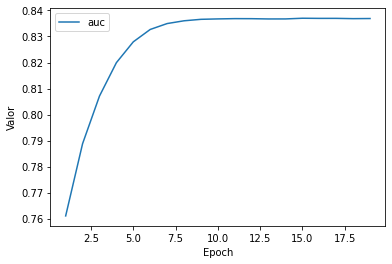

In [29]:
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
          ]

my_model = crear_modelo(learning_rate, feature_layer, METRICS)

epochs, hist = train(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)